kvasir dataset split into neg/pos and trained using resnet50 without augmentation. With rejection resampling (see https://www.tensorflow.org/guide/data#resampling)

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import IPython.display as display
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

%matplotlib inline

In [2]:
MODEL = 'resnet50'
DS_INFO = 'binary'
NUM_EPOCHS = 10
BATCH_SIZE = 64
IMG_HEIGHT = 128  #224
IMG_WIDTH = 128

NUM_CHANNELS = 3
NUM_CLASSES = 2
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

In [3]:
def print_class_info(names, pos, neg):
    # Extract and print info about the class split 
    
    list_class = [pos, neg]
    idx = 1
    for class_ in list_class:
        print ("{} class names:".format(names[idx]))
        for cl in class_:
            print ("{}- {}".format(" "*8, cl))
        idx -= 1
    
    neg_count = 0
    pos_count = 0
    for class_name in original_class_names:
        # Number of samples in 'class_name' folder
        class_samples = len(list(data_dir.glob(class_name+'/*.*g')))

        if (class_name == neg_class_name[0]):
            neg_count += class_samples
        else:
            pos_count += class_samples

    print ('\nNegative samples: {0:5} | {1:5.2f}%'.format(neg_count, neg_count/DATASET_SIZE*100))
    print ('Positive samples: {0:5} | {1:5.2f}%'.format(pos_count, pos_count/DATASET_SIZE*100))
    # Print number of images in dataset (excluded samples in outcast)
    print ('\nTotal number of images:', DATASET_SIZE)

In [4]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')
# data_dir = pathlib.Path('/home/henriklg/master-thesis/data/kvasir-dataset-v2/')
outcast = 'None'

DATASET_SIZE = len(list(data_dir.glob('[!'+str(outcast)+']*/*.*g')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
print ("Classes in data_dir: ", class_names)

# Remove outcasts
original_class_names = np.delete(class_names, np.where(outcast == class_names))
print ("\nRemoved outcast: ", outcast, "\n")

class_names = np.array(['Negative','Positive'])
neg_class_name = ['ship'] # 'normal'-class
pos_class_names = np.delete(original_class_names, np.where(neg_class_name == original_class_names))

print_class_info(class_names, pos_class_names, neg_class_name)

Classes in data_dir:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']

Removed outcast:  None 

Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog
Negative class names:
        - ship

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000


In [5]:
# Create a dataset of the file paths | data_dir/*/* but subract class
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!')+str(outcast+']*/*'))

Set up pipeline for loading images from given list of paths

In [6]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class_names
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.constant(1, tf.int32)
    return tf.constant(0, tf.int32)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

<Figure size 432x288 with 0 Axes>

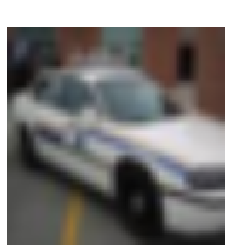

In [7]:
def show_image(img):
    if (isinstance(img, tf.data.Dataset)):
        for image, label in img:
            plt.figure();
            plt.figure(frameon=False, facecolor='white')
            plt.title(class_names[label.numpy()], fontdict={'color':'white','size':20})
            plt.imshow(image.numpy())
            plt.axis('off')
    else:
        plt.figure()
        plt.figure(frameon=False, facecolor='white')
#         plt.title(class_names[label.numpy()], fontdict={'color':'white','size':20})
        plt.imshow(img.numpy())
        plt.axis('off')

# Take one image
show_image(labeled_ds.take(1))

### Resampling the dataset to a 50/50 distribution
https://www.tensorflow.org/guide/data#resampling

In [37]:
# Make large batches to be certain a good amount of minority class makes it in
BATCH_SIZE = 1024
labeled_ds = labeled_ds.batch(BATCH_SIZE)

In [ ]:
for images, labels in labeled_ds.take(1):
    print (labels)
    print (images.dtype, images.shape)
    print (labels.dtype, labels.shape)

In [ ]:
def count(counts, batch):
        images, labels = batch
        
        class_1 = labels == 1
        class_1 = tf.cast(class_1, tf.int32)

        class_0 = labels == 0
        class_0 = tf.cast(class_0, tf.int32)

        counts['class_0'] += tf.reduce_sum(class_0)
        counts['class_1'] += tf.reduce_sum(class_1)

        return counts

In [ ]:
counts = labeled_ds.take(10).reduce(
        initial_state={'class_0': 0, 'class_1': 0},
        reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

counts_sum = counts.sum()
assert counts_sum != 0, "Can't divide by zero"

fractions = counts/counts_sum
print("Fractions: ", fractions)
print("Counts: ", counts)

In [ ]:
# data.experimental.rejection_resample takes a class_func argument. 
# This class_func is applied to each dataset element, 
# and is used to determine which class an example belongs to for the purposes of balancing.

def class_func(image, label):
    return label

In [26]:
# The resampler also needs a target distribution, and optionally an initial distribution estimate:

resampler = tf.data.experimental.rejection_resample(
            class_func, #=lambda image, label: label, 
            target_dist=[0.5, 0.5], 
            initial_dist=fractions)

In [27]:
resample_ds = labeled_ds.unbatch().apply(resampler).batch(10)

In [32]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [28]:
# take one batch
new_labels, images_and_labels = next(iter(resample_ds))

In [29]:
new_labels?

Type:            EagerTensor
String form:     tf.Tensor([0 0 0 0 0 1 0 1 1 0], shape=(10,), dtype=int32)
Length:          10
File:            ~/anaconda3/envs/TF2/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py
Docstring:       <no docstring>
Class docstring: Base class for EagerTensor.


In [30]:
images_and_labels?

Type:        tuple
String form:
(<tf.Tensor: id=782, shape=(10, 128, 128, 3), dtype=float32, numpy=
           array([[[[0.10196079, 0.12156 <...> sor: id=783, shape=(10,), dtype=int32, numpy=array([1, 1, 0, 1, 1, 1, 0, 0, 1, 1], dtype=int32)>)
Length:      2
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.


<Figure size 432x288 with 0 Axes>

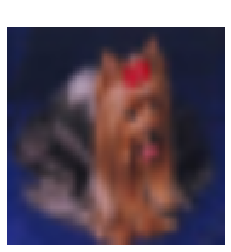

<Figure size 432x288 with 0 Axes>

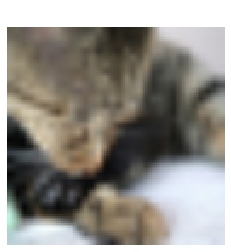

<Figure size 432x288 with 0 Axes>

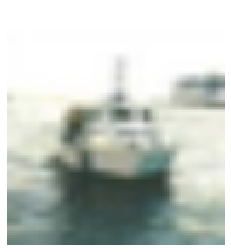

<Figure size 432x288 with 0 Axes>

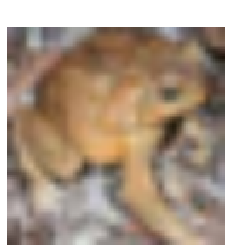

<Figure size 432x288 with 0 Axes>

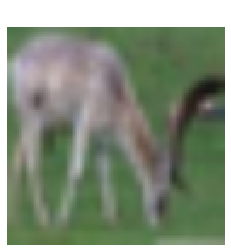

<Figure size 432x288 with 0 Axes>

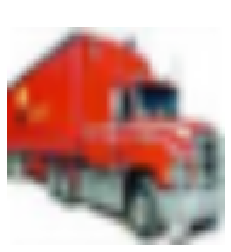

<Figure size 432x288 with 0 Axes>

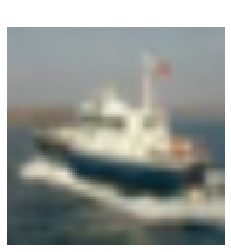

<Figure size 432x288 with 0 Axes>

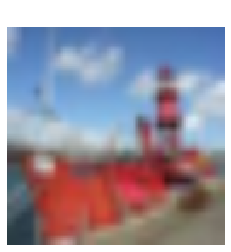

<Figure size 432x288 with 0 Axes>

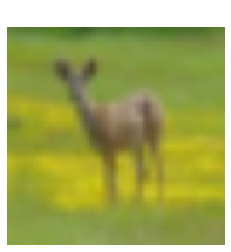

<Figure size 432x288 with 0 Axes>

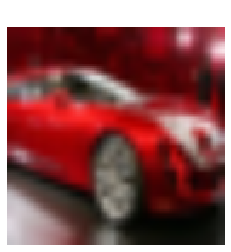

In [31]:
ex_img, ex_label = np.asarray(images_and_labels)
idx = 0
for img in ex_img:
    lab = ex_label
    plt.figure()
    plt.figure(frameon=False, facecolor='white')
    plt.title(str(ex_label[idx].numpy()), fontdict={'color':'white','size':20})
    plt.imshow(img)
    plt.axis('off')
    idx += 1

# plt.figure()
# plt.figure(frameon=False, facecolor='white')
# plt.imshow(img.numpy())

In [ ]:
for images, labels in balanced_ds.take(10):
    labels = labels.numpy()
    total = len(labels)
    
    ones = np.count_nonzero(labels)
    zeros = total - ones
    
    print (labels)
    print ("ones: ", ones)
    print ("zeros: ", zeros)
    print ("total: ", total, "\n")
    
#     images_ = np.asarray(images)
#     im = images_[0][1] 
#     lab = images_[1][1]
#     print ("label: ", lab.numpy())
#     plt.figure()
#     plt.figure(frameon=False, facecolor='white')
#     plt.imshow(im.numpy())
    
#     print(‘Labels:’, [item[1][0] for item in cat]) 
#      l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

In [ ]:
test = np.asarray(images)

for i in range(10):
    print ("indeks: ",i)
    im = test[0][i]
    lab = test[1][i]
    show_image(im)


# idx = np.random.randint(10)
# print ("Sample of batch: ", idx)

# im = test[0][idx]
# lab = test[1][idx]

# print (lab.numpy())
# show_image(im)

In [35]:
# Verify that it has been resampled

counts = balanced_ds.take(30).reduce(
        initial_state={'class_0': 0, 'class_1': 0},
        reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

print(counts/counts.sum())

[0.1 0.9]


### Splitting into training, test and validation data

In [ ]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = labeled_ds#.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [ ]:
# Print info about the dataset split
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/{}_train.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/{}_test.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/{}_val.tfcache".format(IMG_WIDTH))

# Training

### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [22]:
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [23]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [24]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [25]:
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(MODEL), update_freq='batch')]

In [26]:
history = cnn_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

Train for 546 steps, validate for 117 steps
Epoch 1/5
546/546 [==============================] - 5s 8ms/step - loss: 0.3036 - accuracy: 0.8748 - val_loss: 0.2425 - val_accuracy: 0.9046
Epoch 2/5
546/546 [==============================] - 3s 6ms/step - loss: 0.1744 - accuracy: 0.9307 - val_loss: 0.2151 - val_accuracy: 0.9181
Epoch 3/5
546/546 [==============================] - 3s 5ms/step - loss: 0.1262 - accuracy: 0.9529 - val_loss: 0.1494 - val_accuracy: 0.9466
Epoch 4/5
546/546 [==============================] - 3s 6ms/step - loss: 0.0937 - accuracy: 0.9640 - val_loss: 0.1208 - val_accuracy: 0.9557
Epoch 5/5
546/546 [==============================] - 3s 6ms/step - loss: 0.0738 - accuracy: 0.9726 - val_loss: 0.0732 - val_accuracy: 0.9741


`Keras`
Save/load the model

In [27]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

In [28]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=val_size//BATCH_SIZE)

117/117 - 20s - loss: 10.4981 - accuracy: 0.0264


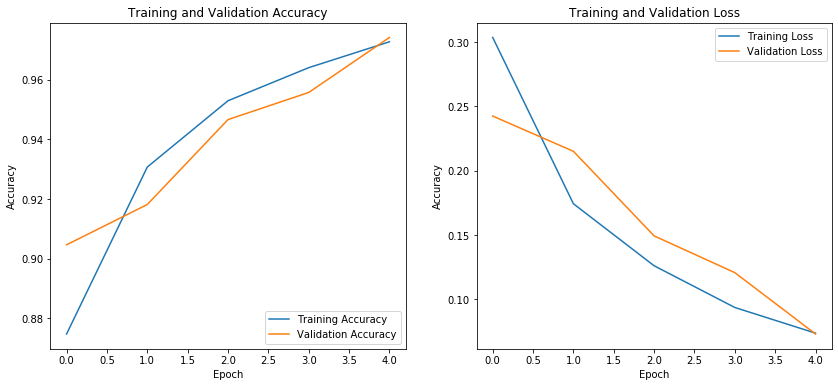

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [30]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

In [ ]:
# Get a random image and label
rand = np.random.randint(0, BATCH_SIZE)
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions, start=-1):
    print("{:0.4f} | {}".format(pred, class_names[np.abs(i)]))

prediction = ('Boat') if np.argmax(predictions)==1 else ('Not boat')

print ("Image {} of {}".format(rand, BATCH_SIZE))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [ ]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, pred in enumerate(predictions):
    label = class_names[labels[i]][0:3]
    prediction = class_names[np.argmin(pred)][0:3]
    print ('\n{:3}  {:5}  {:5}'.format(i, label, prediction), end='')
    if (label != prediction): print ("Wrong", end='')